# Trabalho prático II - Classificação

O objetivo deste trabalho é praticar os conceitos de aprendizado supervisionado que vimos em sala.

A sua tarefa será treinar um classificador para um conjunto de dados misterioso (se eu falasses qual é o objetivo do modelo, você encontraria soluções na Internet).

Baixe o arquivo [t2.tar.gz](https://drive.google.com/file/d/125plHKUzFGxHjjCiVJcTQG2bPG_zgDNV/view?usp=sharing). Descoprima este arquivo para encontrar outros quatro. Os arquivos `train_X.csv` e `train_y.csv` possuem os dados que você deve usar para treinar o modelo. O arquivo `test_X.csv` possui os objetos para os quais você deve encontrar as classes (testar o modelo). Por fim, o arquivo `test_example_y.csv` é um exemplo de como sua solução final deve ser organizada.

Cada linha dos arquivos `train_X.csv` e `test_X.csv` tem 15 campos descrevendo um objeto misterioso. O campo `id` representa o identificador do objeto, sendo que este campo não deve ser considerado em seu modelo. Os atributos a serem usados no modelo são os 14 campos rotulados de de `a` até `n`. Desses atributos:
- `b`, `d`, `f`, `g`, `h`, `i`, `j` e `n` são categóricos; e
- `a`, `c`, `e`, `k`, `l` e `m` são numéricos.

Cada linha do arquivo `train_y.csv` possui dois campos. O primeiro é o identificador de um objeto do arquivo `train_X.csv` e o segundo é a classe do respectivo objeto (0 ou 1).

Seu objetivo é encontrar as classes dos objetos do arquivo `test_X.csv` e mostrar como chegou em sua solução! Os dados do arquivo de teste foram obtido a partir de uma amostra aleatório do todo. Ou seja, um modelo bem treinado, e sem _overfitting_, em `train_X.csv` e `train_y.csv` se sairá bem em `test_X.csv`.

**Data de entrega:** dia 4 de julho de 2018.

**Grupo:** de até 3 pessoas, mas duas pessoas do mesmo grupo no trabalho 1 não podem pertencer ao mesmo grupo nesse trabalho.

**Valor:** 20% da nota do semestre.

Os três seguintes pontos descrevem o que obrigatoriamente deve ser entregue, com seu respectivo valor.

1 - **[10 pontos]** Este notebook com todo seu código e resultados (números, tabelas e gráficos). Você pode usar qualquer um dos métodos que estudamos ou alguma de suas variações próximas. Se estiver na dúvida se pode usar um método, basta perguntas no Piazza. Comentários e justificativas no notebook não serão considerados para sua nota.
O notebook deve ser enviado para o email do professor.

2 - **[8 pontos]** Um relatório digitado contendo: capa, introdução, metodologia, resultados, conclusão e referências. O relatório deve ter no máximo 10 páginas, com coluna simples, fonte 11, espaçamento 1.5 e margens de 2cm. A seção de metodologia deve conter uma descrição detalhada dos passos seguidos (não incluir código no relatório). A seção de resultados deve conter obrigatoriamente: uma caracterização descritiva dos dados, matriz de confusão das predições, _precision_, _recall_, _F1 score_ e acurácia. Todas as métricas de predição devem ser calculadas a partir dos arquivos de treinamento por meio de validação cruzada.
O relatório deve ser enviado para o email do professor.

3 - **[2 pontos + equivalente a lista extra pela classificação]** A sua predição final do arquivo `test_X.csv` deve ser enviada para o professor por email. O formato deve ser o mesmo do arquivo `train_y.csv`, assim como exemplificado em `test_example_y.csv` (mas repare que as classes desse último arquivo foram gerados de forma aleatória). Em outras palavras, o arquivo a ser entregue deve ter dois campos. O campo `id` é o identificador do objeto em `test_X.csv` e o campo `label` é a classe que seu modelo encontrou para o objeto em questão. A primeira linha do arquivo deve conter os nomes das colunas.
A entrega desse arquivo é obrigatória e vale dois pontos. Além disso, o trabalho com maior _F1 score_ ganhará o equivalente a 100% de uma lista extra. O trabalho com o pior _F1 score_ não ganhará nota extra alguma. Os demais trabalhos terão nota proporcional.
O professor se reserva o direito de anular esse quesito (nota extra) se houver indícios de má conduta durante a competição.

**Kaggle:** Estou tentando criar uma competição para esse trabalho na plataforma _Kaggle_. Se eu conseguir, compartilho o _link_ com você no _Piazza_.

### Bibliotecas

In [1]:
import pandas as pd
import sklearn.feature_selection as features
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.externals import joblib
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import tree, svm
import numpy as np
import graphviz
import matplotlib.pyplot as plt
import itertools

### Processamento dos arquivos e normalização dos dados

In [12]:
division = 40222

X = pd.concat([pd.read_csv('data/train_X.csv'),pd.read_csv('data/test_X.csv')])
X = pd.DataFrame(OneHotEncoder(categorical_features = [2,4,6,7,8,9,10,14],sparse=False).fit_transform(X))


ids = X[98]
X = X.drop(columns=[98])

for column in X:
    X[column] = (X[column] - X[column].min()) / (X[column].max() - X[column].min())
    
X.insert(loc=0, column="id", value=ids)

X.rename(inplace=True, columns={99:"a",100:"c",101:"e",102:"k",103:"l",104:"m"})

trainX = X[:division]
testX = X[division:]

trainX.to_csv("data/pd_trainX.csv", index=False)
testX.to_csv("data/pd_testX.csv", index=False)

In [2]:
X = pd.read_csv("data/pd_trainX.csv")
y = pd.read_csv("data/train_Y.csv")
testX = pd.read_csv("data/pd_testX.csv")
        
X = X.drop(columns=["id"]).values
y = (y.drop(columns=["id"]).T).values[0]

In [3]:
print(X, end='\n\n')
print(y)

[[0.         0.         1.         ... 0.         0.         0.29591837]
 [0.         1.         0.         ... 0.         0.         0.37755102]
 [0.         0.         1.         ... 0.         0.         0.39795918]
 ...
 [0.         0.         1.         ... 0.         0.         0.5       ]
 [0.         0.         0.         ... 0.         0.         0.39795918]
 [1.         0.         0.         ... 0.         0.         0.39795918]]

[0 0 0 ... 1 1 1]


In [16]:
testX

,id,0,1,2,3,4,5,6,7,8,...,94,95,96,97,a,c,e,k,l,m
0,16432.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.013699,0.172301,0.400000,0.000000,0.000000,0.142857
1,11559.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.205479,0.213920,0.866667,0.000000,0.000000,0.397959
2,7714.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.410959,0.074608,0.866667,0.076881,0.000000,0.602041
3,11576.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.260274,0.127311,0.800000,0.000000,0.000000,0.397959
4,10336.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.013699,0.120268,0.400000,0.000000,0.000000,0.193878
5,11249.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.424658,0.071419,0.333333,0.000000,0.000000,0.397959
6,11030.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.136986,0.018692,0.533333,0.000000,0.000000,0.295918
7,10292.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.246575,0.062316,0.533333,0.000000,0.000000,0.397959
8,13980.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.315068,0.103136,0.600000,0.000000,0.000000,0.397959
9,5558.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.328767,0.147226,0.533333,0.000000,0.000000,0.397959


### Definição de funções

In [4]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks([])
    plt.yticks([])

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
def create_scores_df(model):
    predicted = model.predict(X_test)
    scores ={"Accuracy Score": [accuracy_score(y_test, predicted)],
            "F1 Score": [f1_score(y_test, predicted)],
            "Precision Score": [precision_score(y_test, predicted)],
            "Recall Score": [recall_score(y_test, predicted)]}

    return pd.DataFrame(data=scores)

### Divisão do conjunto de treino/teste

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [20]:
print(X_train, len(X_train), sep = '\n\n')

[[0.         0.         1.         ... 0.         0.         0.39795918]
 [0.         0.         1.         ... 0.         0.         0.96938776]
 [0.         0.         1.         ... 0.         0.         0.39795918]
 ...
 [0.         0.         1.         ... 0.         0.         0.39795918]
 [0.         0.         1.         ... 0.         0.         0.39795918]
 [0.         0.         1.         ... 0.         0.         0.60204082]]

26948


In [21]:
print(X_test, len(X_test), sep = '\n\n')

[[0.         0.         1.         ... 0.         0.         0.39795918]
 [0.         0.         0.         ... 0.         0.         0.39795918]
 [0.         0.         0.         ... 0.         0.         0.39795918]
 ...
 [0.         1.         0.         ... 0.1502415  0.         0.60204082]
 [0.         1.         0.         ... 0.         0.         0.5       ]
 [0.         0.         1.         ... 0.         0.         0.09183673]]

13274


In [22]:
print(y_train, len(y_train), sep = '\n\n')

[0 0 0 ... 1 0 1]

26948


In [23]:
print(y_test, len(y_test), sep = '\n\n')

[1 0 0 ... 1 0 0]

13274


### Multinomial NB

#### Treino e matriz de confusão

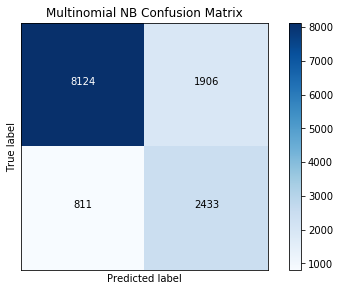

In [15]:
nb_mult = MultinomialNB()
nb_mult.fit(X_train, y_train)
joblib.dump(nb_mult, 'models/multinomial_nb.pkl') 

plot_confusion_matrix(confusion_matrix(y_test, nb_mult.predict(X_test)), title="Multinomial NB Confusion Matrix")

#### Tabela de scores

In [16]:
df_scores_nb_mult = create_scores_df(nb_mult)
df_scores_nb_mult

,Accuracy Score,F1 Score,Precision Score,Recall Score
0,0.795314,0.641699,0.560728,0.75


### Decision Tree

#### Treino e matriz de confusão

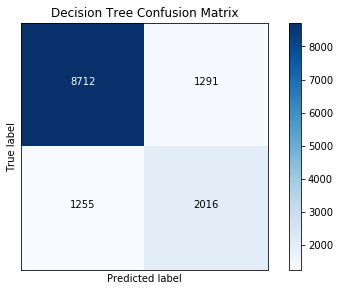

In [45]:
dt = tree.DecisionTreeClassifier()
dt.fit(X_train, y_train)
joblib.dump(dt, 'models/dt.pkl') 

plot_confusion_matrix(confusion_matrix(y_test, dt.predict(X_test)), title="Decision Tree Confusion Matrix")

#### Exportando a árvore utilizando graphviz

In [60]:
dot_data = tree.export_graphviz(dt, out_file=None,
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = graphviz.Source(dot_data).view()

#### Tabela de scores

In [46]:
df_scores_dt = create_scores_df(dt)
df_scores_dt

,Accuracy Score,F1 Score,Precision Score,Recall Score
0,0.808196,0.612952,0.609616,0.616325


### Random Forest Classifier

#### Treino e matriz de confusão

Fitting 3 folds for each of 31 candidates, totalling 93 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 26.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 34.8min
[Parallel(n_jobs=-1)]: Done  88 out of  93 | elapsed: 47.7min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed: 63.4min finished


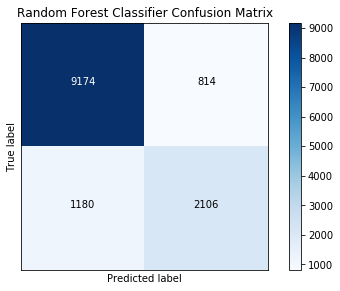

In [19]:
params_rfc = {'n_estimators': list(range(3000, 6001, 100))}

rfc = GridSearchCV(RandomForestClassifier(), params_rfc, "f1", n_jobs=-1, verbose = 10) 
rfc.fit(X_train, y_train)

plot_confusion_matrix(confusion_matrix(y_test, rfc.predict(X_test)), title="Random Forest Classifier Confusion Matrix")

#### Melhor estimador

In [20]:
rfc.best_estimator_
joblib.dump(rfc.best_estimator_, 'models/best_rfc.pkl') 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=4800, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Tabela de scores

In [21]:
df_scores_rfc = create_scores_df(rfc)
df_scores_rfc

,Accuracy Score,F1 Score,Precision Score,Recall Score
0,0.849782,0.678698,0.721233,0.640901


### Linear SVC

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  2.2min
[Paralle

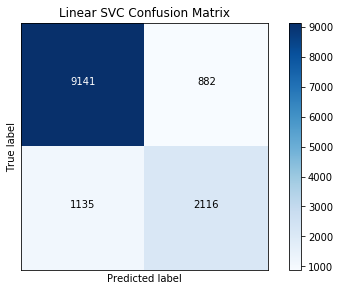

In [37]:
params_lin_svc = {'C': np.linspace(20, 50, 100), "tol": [1e-3, 1e-4]}

lin_svc = GridSearchCV(svm.LinearSVC(), params_lin_svc, "f1", n_jobs = -1, verbose = 10)
lin_svc.fit(X_train, y_train)

plot_confusion_matrix(confusion_matrix(y_test, lin_svc.predict(X_test)), title="Linear SVC Confusion Matrix")

#### Melhor estimador

In [38]:
joblib.dump(lin_svc.best_estimator_, 'models/best_lin_svc.pkl') 
lin_svc.best_estimator_

LinearSVC(C=46.66666666666667, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)

#### Tabela de scores

In [39]:
df_scores_lin_svc = create_scores_df(lin_svc)
df_scores_lin_svc

,Accuracy Score,F1 Score,Precision Score,Recall Score
0,0.848049,0.677228,0.705804,0.650877


### SVC

#### Treino e matriz de confusão

In [ ]:
C_range = np.logspace(-2, 10, 15)
gamma_range = np.logspace(-9, 3, 15)

params_svc = {'C': C_range , 'gamma': gamma_range, 
              'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

svc = GridSearchCV(svm.SVC(class_weight='balanced', cache_size=12000), params_svc, "f1", n_jobs = -1, verbose = 10)
svc.fit(X_train, y_train)

plot_confusion_matrix(confusion_matrix(y_test, svc.predict(X_test)), title="SVC Confusion Matrix")

Fitting 3 folds for each of 900 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 34.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 44.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 53.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 61.7min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 73.8min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 83.6min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 92.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 110.0min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 141.6min


c:\users\gabgo\documents\github\data-mining-w2\venv\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


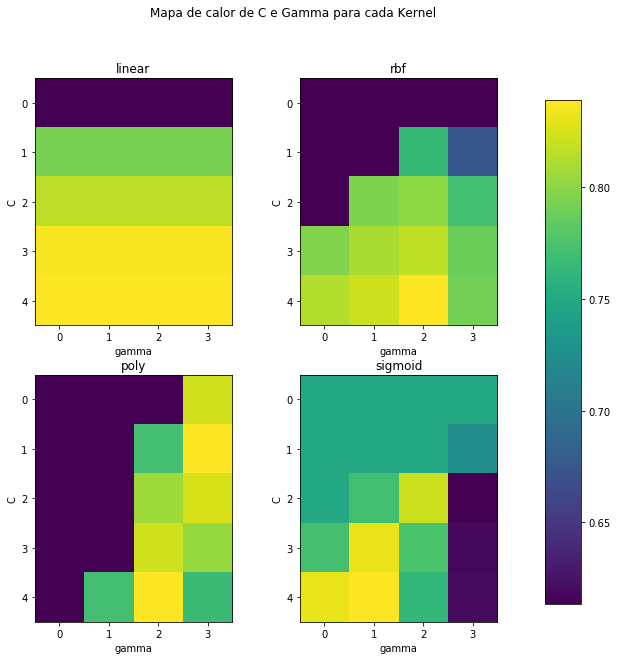

In [71]:
plt.rcParams['figure.figsize'] = 10, 10

score_dict = svc.grid_scores_
i = j = 0
fig, axes = plt.subplots(2, 2)
for kernel in ['linear', 'rbf', 'poly', 'sigmoid']:
    scores = [x[1] for x in score_dict if x[0]['kernel'] == kernel]
    scores = np.array(scores).reshape(len(C_range), len(gamma_range))

    im = axes[i, j].imshow(scores, interpolation='nearest')
    axes[i, j].set_xlabel('gamma')
    axes[i, j].set_ylabel('C')
    #axes[i, j].set_xticks(np.arange(len(gamma_range)), gamma_range)
    #axes[i, j].set_yticks(np.arange(len(C_range)), C_range)
    #axes[i, j].set_xticklabels([0.001, 0.01, 0.1, 1])
    #axes[i, j].set_yticklabels([0.001, 0.01, 0.1, 1, 10])
    axes[i, j].set_title(kernel) 
    
    j += 1
    if j == 2:
        j = 0
        i += 1

for i in range(2):
    for j in range(2):
        axes[i, j].set_xticklabels([0.001, 0.01, 0.1, 1])
        axes[i, j].set_yticklabels([0.001, 0.01, 0.1, 1, 10])
plt.suptitle("Mapa de calor de C e Gamma para cada Kernel")    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)      

#### Melhor estimador

In [11]:
joblib.dump(svc.best_estimator_, 'models/svc_best.pkl')
svc.best_estimator_

SVC(C=10, cache_size=12000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Tabela de scores

In [25]:
df_scores_svc = create_scores_df(svc)
df_scores_svc

,Accuracy Score,F1 Score,Precision Score,Recall Score
0,0.792753,0.666586,0.55,0.845894


### Busca no SVC por kernel

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 37.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 46.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 59.0min
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed: 76.2min remaining:  7.8min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 82.3min finished


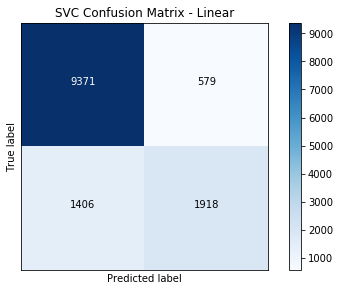

In [7]:
C_range = np.linspace(10, 20, num=5)
gamma_range = [0.001, 0.01, 0.1, 1, 10]

params_svc = {'C': C_range , 'gamma': gamma_range, 
              'kernel': ['linear']}

svc = GridSearchCV(svm.SVC(cache_size=12000), params_svc, "f1", n_jobs = -1, verbose = 10)
svc.fit(X_train, y_train)

plot_confusion_matrix(confusion_matrix(y_test, svc.predict(X_test)), title="SVC Confusion Matrix - Linear")

In [8]:
df_scores_svc = create_scores_df(svc)
df_scores_svc

,Accuracy Score,F1 Score,Precision Score,Recall Score
0,0.85046,0.658993,0.768122,0.577016


In [ ]:
C_range = np.linspace(10, 50, num=5)
gamma_range = np.linspace(0.1, 5, num=5)
#C_range = [0.001, 0.01, 0.1, 1, 10]
#gamma_range = [0.001, 0.01, 0.1, 1]

params_svc = {'C': C_range , 'gamma': gamma_range, 
              'kernel': ['rbf']}

svc_rbf = GridSearchCV(svm.SVC(cache_size=12000), params_svc, "f1", n_jobs = -1, verbose = 10)
svc_rbf.fit(X_train, y_train)

plot_confusion_matrix(confusion_matrix(y_test, svc_rbf.predict(X_test)), title="SVC Confusion Matrix - RBF")

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 16.2min


### Essemble (testar)

In [ ]:
svc_best = joblib.load('models/svc_best.pkl')
lin_svc = joblib.load('models/lin_svc.pkl')
rfc = joblib.load('models/rfc.pkl')

vc = VotingClassifier(estimators=[('rfc', rfc), ('lin_svc', lin_svc), ('svc_best', svc_best)], 
                      voting='hard', n_jobs=-1)
vc.fit(X_train, y_train)

plot_confusion_matrix(confusion_matrix(y_test, vc.predict(X_test)), title="SVC Confusion Matrix")

In [ ]:
df_scores_vc = create_scores_df(vc)
df_scores_vc